In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Cấu hình style cho biểu đồ
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 16
sns.set_palette("husl")

In [2]:
# Load dữ liệu
print("📂 Đang tải dữ liệu...")
df_events = pd.read_csv('../data/udk_moodle_log.csv')
df_grades = pd.read_csv('../data/udk_moodle_all_grades.csv')

# Xử lý thời gian
df_events['datetime'] = pd.to_datetime(df_events['timecreated'], unit='s')
df_grades['datetime'] = pd.to_datetime(df_grades['timemodified'], unit='s')

print(f"✅ Events: {len(df_events):,} records")
print(f"✅ Grades: {len(df_grades):,} records")

📂 Đang tải dữ liệu...
✅ Events: 1,259,411 records
✅ Grades: 20,317 records


In [3]:
# Tính toán các thống kê tổng quan
total_users = df_events['userid'].nunique()
total_courses = df_events['courseid'].nunique()
total_events = len(df_events)
total_grades = len(df_grades[df_grades['finalgrade'] >= 0])

# Phân tích điểm số (loại bỏ giá trị -1)
valid_grades = df_grades[df_grades['finalgrade'] >= 0]['finalgrade']
avg_grade = valid_grades.mean()
grade_std = valid_grades.std()

# Phân tích hoạt động theo thời gian
df_events['date'] = df_events['datetime'].dt.date
daily_activity = df_events.groupby('date').size()

# Hoạt động của user
user_activity = df_events.groupby('userid').size()
avg_events_per_user = user_activity.mean()

print(f"📊 Tổng số users: {total_users:,}")
print(f"📚 Tổng số courses: {total_courses:,}")
print(f"🎯 Điểm trung bình: {avg_grade:.2f} ± {grade_std:.2f}")
print(f"⚡ Trung bình events/user: {avg_events_per_user:.1f}")

📊 Tổng số users: 1,110
📚 Tổng số courses: 897
🎯 Điểm trung bình: 7.70 ± 2.64
⚡ Trung bình events/user: 1134.6


## Biểu đồ tổng quan Dataset


💾 Đang lưu biểu đồ...
✅ Đã lưu: dataset_overview_report.png
✅ Đã lưu: dataset_overview_report.pdf


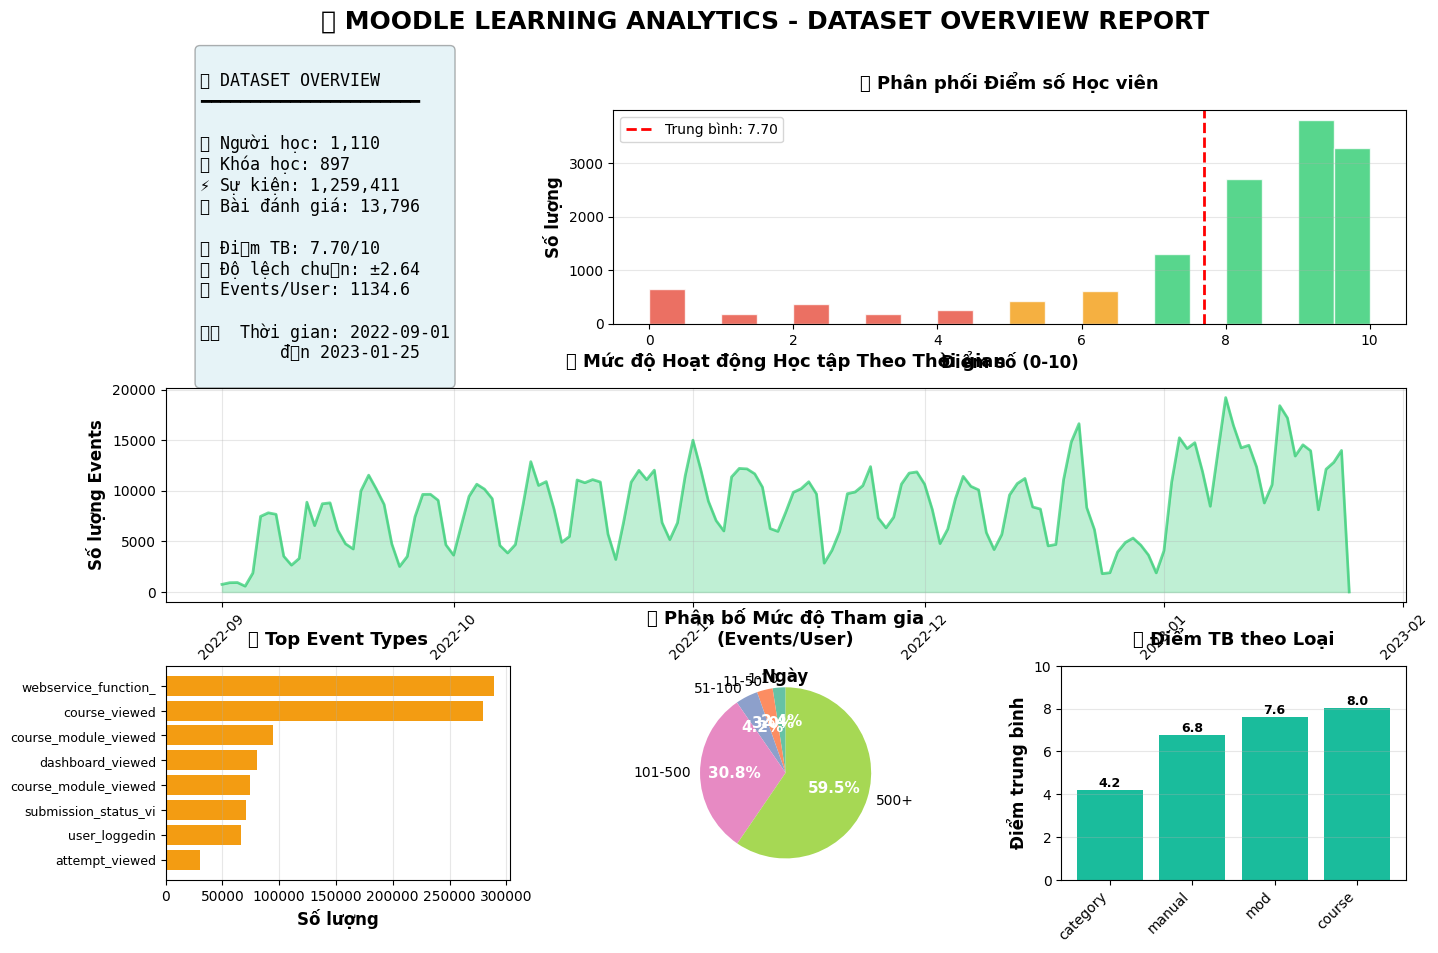


🎉 HOÀN THÀNH! Bạn có thể sử dụng file PNG hoặc PDF cho báo cáo.


In [4]:
# Tạo biểu đồ tổng quan với 6 panels
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Màu sắc chủ đạo
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']

# ============================================================================
# Panel 1: Thống kê tổng quan (text box)
# ============================================================================
ax1 = fig.add_subplot(gs[0, 0])
ax1.axis('off')
stats_text = f"""
📊 DATASET OVERVIEW
━━━━━━━━━━━━━━━━━━━━━━

👥 Người học: {total_users:,}
📚 Khóa học: {total_courses:,}
⚡ Sự kiện: {total_events:,}
📝 Bài đánh giá: {total_grades:,}

🎯 Điểm TB: {avg_grade:.2f}/10
📈 Độ lệch chuẩn: ±{grade_std:.2f}
🔄 Events/User: {avg_events_per_user:.1f}

⏱️  Thời gian: {df_events['datetime'].min().strftime('%Y-%m-%d')}
        đến {df_events['datetime'].max().strftime('%Y-%m-%d')}
"""
ax1.text(0.1, 0.5, stats_text, fontsize=12, family='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3),
         verticalalignment='center')

# ============================================================================
# Panel 2: Phân phối điểm số
# ============================================================================
ax2 = fig.add_subplot(gs[0, 1:])
n, bins, patches = ax2.hist(valid_grades, bins=20, color=colors[0], 
                             edgecolor='white', alpha=0.8)
# Tô màu gradient
for i, patch in enumerate(patches):
    if bins[i] < 5:
        patch.set_facecolor('#e74c3c')  # Đỏ cho điểm thấp
    elif bins[i] < 7:
        patch.set_facecolor('#f39c12')  # Cam cho điểm trung bình
    else:
        patch.set_facecolor('#2ecc71')  # Xanh cho điểm cao

ax2.axvline(avg_grade, color='red', linestyle='--', linewidth=2, 
            label=f'Trung bình: {avg_grade:.2f}')
ax2.set_xlabel('Điểm số (0-10)', fontweight='bold')
ax2.set_ylabel('Số lượng', fontweight='bold')
ax2.set_title('📊 Phân phối Điểm số Học viên', fontweight='bold', pad=15)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# ============================================================================
# Panel 3: Hoạt động theo thời gian
# ============================================================================
ax3 = fig.add_subplot(gs[1, :])
daily_activity.plot(ax=ax3, color=colors[2], linewidth=2, alpha=0.7)
ax3.fill_between(daily_activity.index, daily_activity.values, alpha=0.3, color=colors[2])
ax3.set_xlabel('Ngày', fontweight='bold')
ax3.set_ylabel('Số lượng Events', fontweight='bold')
ax3.set_title('⏰ Mức độ Hoạt động Học tập Theo Thời gian', fontweight='bold', pad=15)
ax3.grid(alpha=0.3)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

# ============================================================================
# Panel 4: Top event types
# ============================================================================
ax4 = fig.add_subplot(gs[2, 0])
top_events = df_events['eventname'].value_counts().head(8)
# Rút gọn tên event
event_names = [name.split('\\')[-1][:20] for name in top_events.index]
ax4.barh(range(len(top_events)), top_events.values, color=colors[3])
ax4.set_yticks(range(len(top_events)))
ax4.set_yticklabels(event_names, fontsize=9)
ax4.set_xlabel('Số lượng', fontweight='bold')
ax4.set_title('🎯 Top Event Types', fontweight='bold', pad=15)
ax4.grid(axis='x', alpha=0.3)
ax4.invert_yaxis()

# ============================================================================
# Panel 5: Phân bố user activity
# ============================================================================
ax5 = fig.add_subplot(gs[2, 1])
# Chia thành nhóm activity level
activity_bins = [0, 10, 50, 100, 500, user_activity.max()]
activity_labels = ['1-10', '11-50', '51-100', '101-500', '500+']
user_activity_groups = pd.cut(user_activity, bins=activity_bins, labels=activity_labels)
activity_counts = user_activity_groups.value_counts().sort_index()

wedges, texts, autotexts = ax5.pie(activity_counts, labels=activity_counts.index,
                                     autopct='%1.1f%%', colors=sns.color_palette('Set2'),
                                     startangle=90)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax5.set_title('👥 Phân bố Mức độ Tham gia\n(Events/User)', fontweight='bold', pad=15)

# ============================================================================
# Panel 6: Grade distribution by itemtype
# ============================================================================
ax6 = fig.add_subplot(gs[2, 2])
grade_by_type = df_grades[df_grades['finalgrade'] >= 0].groupby('itemtype')['finalgrade'].mean().sort_values()
bars = ax6.bar(range(len(grade_by_type)), grade_by_type.values, color=colors[5])
ax6.set_xticks(range(len(grade_by_type)))
ax6.set_xticklabels(grade_by_type.index, rotation=45, ha='right')
ax6.set_ylabel('Điểm trung bình', fontweight='bold')
ax6.set_title('📈 Điểm TB theo Loại', fontweight='bold', pad=15)
ax6.set_ylim(0, 10)
ax6.grid(axis='y', alpha=0.3)

# Thêm giá trị trên mỗi cột
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# ============================================================================
# Tiêu đề chính
# ============================================================================
fig.suptitle('📊 MOODLE LEARNING ANALYTICS - DATASET OVERVIEW REPORT', 
             fontsize=18, fontweight='bold', y=0.98)

plt.tight_layout()

# Lưu file với độ phân giải cao
print("\n💾 Đang lưu biểu đồ...")
plt.savefig('dataset_overview_report.png', dpi=300, bbox_inches='tight', facecolor='white')
print("✅ Đã lưu: dataset_overview_report.png")

plt.savefig('dataset_overview_report.pdf', dpi=300, bbox_inches='tight', facecolor='white')
print("✅ Đã lưu: dataset_overview_report.pdf")

plt.show()

print("\n🎉 HOÀN THÀNH! Bạn có thể sử dụng file PNG hoặc PDF cho báo cáo.")

## Kết luận

Biểu đồ trên tổng hợp các thông tin chính về dataset:

1. **Thống kê tổng quan**: Số lượng users, courses, events, và grades
2. **Phân phối điểm số**: Cho thấy phân bố điểm của học viên (màu đỏ: thấp, cam: TB, xanh: cao)
3. **Hoạt động theo thời gian**: Timeline của các hoạt động học tập
4. **Top Event Types**: Các loại sự kiện phổ biến nhất
5. **Mức độ tham gia**: Phân bố user theo số lượng events
6. **Điểm TB theo loại**: So sánh điểm trung bình của các loại đánh giá khác nhau